In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy
import scattertext as st
from IPython.display import display, Markdown
from nltk.sentiment.util import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2

In [4]:
blm_df = pd.read_csv('blm_tweets_for_models.csv', index_col=0)
blm_df.head()

,date,hashtags,nlikes,tweet,username,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized,len,year,month,liked,vader_sent,textblob_sent,avg_sent
0,2020-06-24 16:59:09,['#blm'],20.0,"NO JUSTICE, NO PEACE #BLM",satanic_syd,NO JUSTICE NO PEACE BLM,"['no', 'justice', 'no', 'peace', 'blm', '']","['justice', 'peace', 'blm', '']","['justic', 'peac', 'blm', '']","['justice', 'peace', 'blm', '']",27,2020,6,popular,0.7845,0.000000,0.392250
1,2020-06-24 16:52:19,"['#poem', '#motivation', '#blm']",206.0,Funny thing\nAbout life is\nYou’ll always be t...,derickijohnson,Funny thing\nAbout life is\nYou’ll always be t...,"['funny', 'thing', 'about', 'life', 'is', 'you...","['funny', 'thing', 'life', 'always', 'one', 'e...","['funni', 'thing', 'life', 'alway', 'one', 'el...","['funny', 'thing', 'life', 'always', 'one', 'e...",264,2020,6,popular,0.9081,0.366667,0.637383
2,2020-06-24 16:47:56,['#blm'],23.0,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,AngelofLightLit,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,"['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'woman', 'protect', 'blac...",65,2020,6,popular,0.7783,-0.166667,0.305817
3,2020-06-24 16:46:02,['#blm'],147.0,My kid wrote #blm in chalk on my driveway and ...,Majhatesall,My kid wrote blm in chalk on my driveway and I...,"['my', 'kid', 'wrote', 'blm', 'in', 'chalk', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...",278,2020,6,popular,0.0000,0.100000,0.050000
4,2020-06-24 16:43:54,"['#auspol', '#blm', '#racismeantiblancs', '#vi...",24.0,"Genuflect, prostrate, repent.\n\nRepeat.\n\n🤢🤢...",CaroDiRusso,Genuflect prostrate repent\n\nRepeat\n\n🤢🤢🤢\na...,"['genuflect', 'prostrate', 'repent', 'repeat',...","['genuflect', 'prostrate', 'repent', 'repeat',...","['genuflect', 'prostrat', 'repent', 'repeat', ...","['genuflect', 'prostrate', 'repent', 'repeat',...",96,2020,6,popular,0.0000,0.000000,0.000000


In [5]:
blm_df['date'] = pd.to_datetime(blm_df['date'], infer_datetime_format=True, errors='coerce')
blm_df['nlikes'] = pd.to_numeric(blm_df['nlikes'], errors='coerce')
blm_df = blm_df.dropna()

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)

In [7]:
reindexed_data = blm_df['tweet_lemmatized']

In [8]:
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 6
lsa_model = TruncatedSVD(n_components = n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [9]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix'''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    return a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words

In [10]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [11]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  blm black people
Topic 2:  matter life black
Topic 3:  blacklivesmatter blm justiceforgeorgefloyd
Topic 4:  resist retweet ifb
Topic 5:  people white blacklivesmatter
Topic 6:  protest blm peaceful


In [12]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]


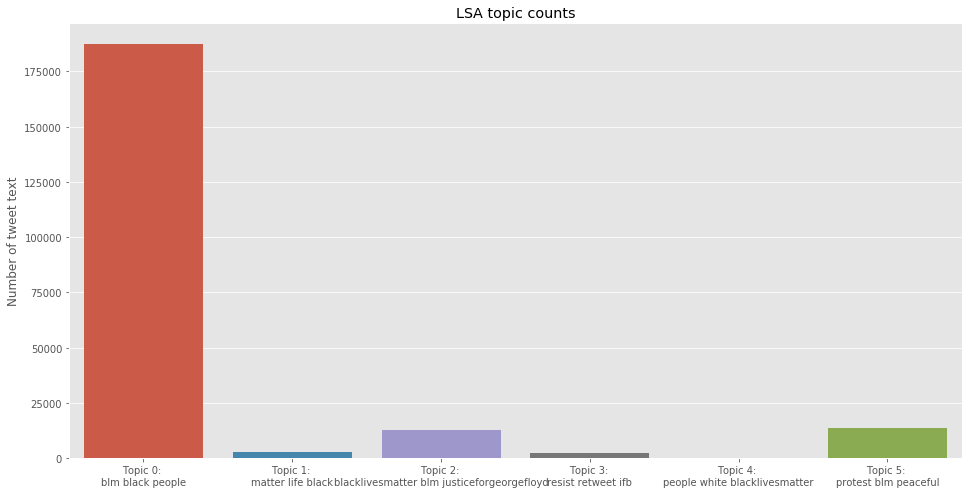

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of tweet text')
ax.set_title('LSA topic counts')
plt.show()

In [14]:
def remove_blm(text):
    '''The input is any text and the output the word blm since it was the search word.'''
    text = re.sub(r"blm\S+","", text)
    return text

In [15]:
blm_df['tweet_lemmatized_no_blm'] = blm_df['tweet_lemmatized'].apply(lambda x: remove_blm(x))
blm_df.head()

,date,hashtags,nlikes,tweet,username,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized,len,year,month,liked,vader_sent,textblob_sent,avg_sent,tweet_lemmatized_no_blm
0,2020-06-24 16:59:09,['#blm'],20.0,"NO JUSTICE, NO PEACE #BLM",satanic_syd,NO JUSTICE NO PEACE BLM,"['no', 'justice', 'no', 'peace', 'blm', '']","['justice', 'peace', 'blm', '']","['justic', 'peac', 'blm', '']","['justice', 'peace', 'blm', '']",27,2020,6,popular,0.7845,0.000000,0.392250,"['justice', 'peace', ' '']"
1,2020-06-24 16:52:19,"['#poem', '#motivation', '#blm']",206.0,Funny thing\nAbout life is\nYou’ll always be t...,derickijohnson,Funny thing\nAbout life is\nYou’ll always be t...,"['funny', 'thing', 'about', 'life', 'is', 'you...","['funny', 'thing', 'life', 'always', 'one', 'e...","['funni', 'thing', 'life', 'alway', 'one', 'el...","['funny', 'thing', 'life', 'always', 'one', 'e...",264,2020,6,popular,0.9081,0.366667,0.637383,"['funny', 'thing', 'life', 'always', 'one', 'e..."
2,2020-06-24 16:47:56,['#blm'],23.0,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,AngelofLightLit,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,"['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'woman', 'protect', 'blac...",65,2020,6,popular,0.7783,-0.166667,0.305817,"['protect', 'black', 'woman', 'protect', 'blac..."
3,2020-06-24 16:46:02,['#blm'],147.0,My kid wrote #blm in chalk on my driveway and ...,Majhatesall,My kid wrote blm in chalk on my driveway and I...,"['my', 'kid', 'wrote', 'blm', 'in', 'chalk', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...",278,2020,6,popular,0.0000,0.100000,0.050000,"['kid', 'wrote', ' 'chalk', 'driveway', 'asked..."
4,2020-06-24 16:43:54,"['#auspol', '#blm', '#racismeantiblancs', '#vi...",24.0,"Genuflect, prostrate, repent.\n\nRepeat.\n\n🤢🤢...",CaroDiRusso,Genuflect prostrate repent\n\nRepeat\n\n🤢🤢🤢\na...,"['genuflect', 'prostrate', 'repent', 'repeat',...","['genuflect', 'prostrate', 'repent', 'repeat',...","['genuflect', 'prostrat', 'repent', 'repeat', ...","['genuflect', 'prostrate', 'repent', 'repeat',...",96,2020,6,popular,0.0000,0.000000,0.000000,"['genuflect', 'prostrate', 'repent', 'repeat',..."


In [16]:
reindexed_data = blm_df['tweet_lemmatized_no_blm']

In [17]:
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 6
lsa_model = TruncatedSVD(n_components = n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [18]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [19]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  black people life
Topic 2:  matter life black
Topic 3:  blacklivesmatter georgefloyd justiceforgeorgefloyd
Topic 4:  resist retweet hello
Topic 5:  protest today peaceful
Topic 6:  justice change sign


In [20]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]



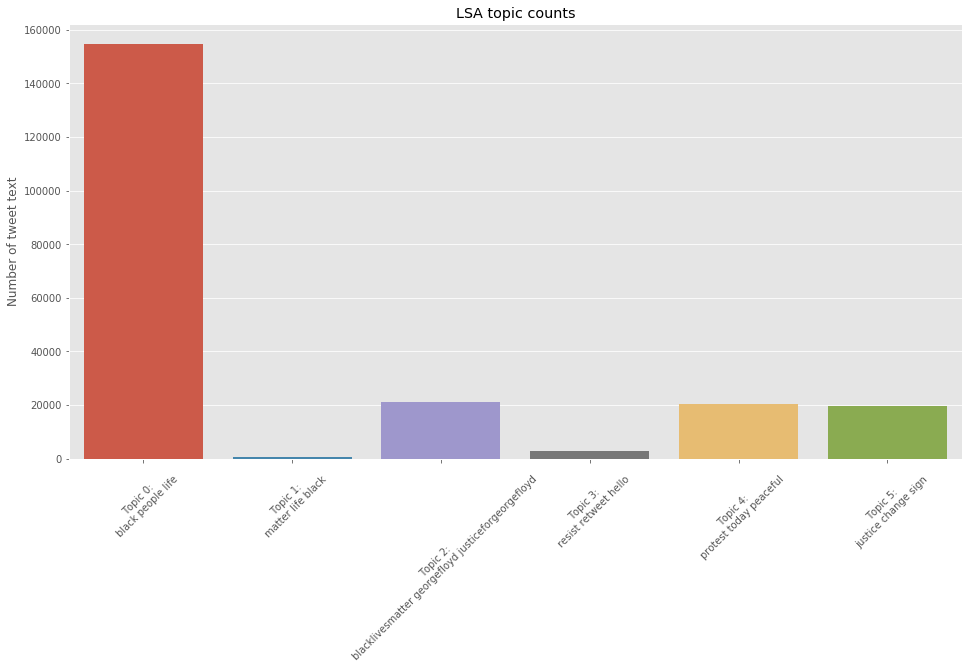

In [21]:
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Number of tweet text')
ax.set_title('LSA topic counts')
plt.show()

In [22]:
blm_df['avg_sent'].describe()

count    218818.000000
mean         -0.006903
std           0.352515
min          -0.994250
25%          -0.286920
50%           0.000000
75%           0.250000
max           0.979500
Name: avg_sent, dtype: float64

In [23]:
blm_df_polarized = blm_df[blm_df['avg_sent'] != 0.0]
blm_df_polarized.head()

,date,hashtags,nlikes,tweet,username,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized,len,year,month,liked,vader_sent,textblob_sent,avg_sent,tweet_lemmatized_no_blm
0,2020-06-24 16:59:09,['#blm'],20.0,"NO JUSTICE, NO PEACE #BLM",satanic_syd,NO JUSTICE NO PEACE BLM,"['no', 'justice', 'no', 'peace', 'blm', '']","['justice', 'peace', 'blm', '']","['justic', 'peac', 'blm', '']","['justice', 'peace', 'blm', '']",27,2020,6,popular,0.7845,0.000000,0.392250,"['justice', 'peace', ' '']"
1,2020-06-24 16:52:19,"['#poem', '#motivation', '#blm']",206.0,Funny thing\nAbout life is\nYou’ll always be t...,derickijohnson,Funny thing\nAbout life is\nYou’ll always be t...,"['funny', 'thing', 'about', 'life', 'is', 'you...","['funny', 'thing', 'life', 'always', 'one', 'e...","['funni', 'thing', 'life', 'alway', 'one', 'el...","['funny', 'thing', 'life', 'always', 'one', 'e...",264,2020,6,popular,0.9081,0.366667,0.637383,"['funny', 'thing', 'life', 'always', 'one', 'e..."
2,2020-06-24 16:47:56,['#blm'],23.0,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,AngelofLightLit,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,"['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'woman', 'protect', 'blac...",65,2020,6,popular,0.7783,-0.166667,0.305817,"['protect', 'black', 'woman', 'protect', 'blac..."
3,2020-06-24 16:46:02,['#blm'],147.0,My kid wrote #blm in chalk on my driveway and ...,Majhatesall,My kid wrote blm in chalk on my driveway and I...,"['my', 'kid', 'wrote', 'blm', 'in', 'chalk', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...",278,2020,6,popular,0.0000,0.100000,0.050000,"['kid', 'wrote', ' 'chalk', 'driveway', 'asked..."
5,2020-06-24 16:39:31,"['#blm', '#blacklivesmatter']",25.0,We are not done fighting folks.\n\nDon't let t...,49ersMike_NFL,We are not done fighting folks\n\nDont let the...,"['we', 'are', 'not', 'done', 'fighting', 'folk...","['done', 'fighting', 'folks', 'dont', 'let', '...","['done', 'fight', 'folk', 'dont', 'let', 'time...","['done', 'fighting', 'folk', 'dont', 'let', 't...",129,2020,6,popular,-0.0243,0.200000,0.087850,"['done', 'fighting', 'folk', 'dont', 'let', 't..."


In [24]:
blm_df_polarized['positivity'] = np.where(blm_df_polarized['avg_sent'] > 0, 1, 0)
blm_df_polarized.head()

,date,hashtags,nlikes,tweet,username,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized,len,year,month,liked,vader_sent,textblob_sent,avg_sent,tweet_lemmatized_no_blm,positivity
0,2020-06-24 16:59:09,['#blm'],20.0,"NO JUSTICE, NO PEACE #BLM",satanic_syd,NO JUSTICE NO PEACE BLM,"['no', 'justice', 'no', 'peace', 'blm', '']","['justice', 'peace', 'blm', '']","['justic', 'peac', 'blm', '']","['justice', 'peace', 'blm', '']",27,2020,6,popular,0.7845,0.000000,0.392250,"['justice', 'peace', ' '']",1
1,2020-06-24 16:52:19,"['#poem', '#motivation', '#blm']",206.0,Funny thing\nAbout life is\nYou’ll always be t...,derickijohnson,Funny thing\nAbout life is\nYou’ll always be t...,"['funny', 'thing', 'about', 'life', 'is', 'you...","['funny', 'thing', 'life', 'always', 'one', 'e...","['funni', 'thing', 'life', 'alway', 'one', 'el...","['funny', 'thing', 'life', 'always', 'one', 'e...",264,2020,6,popular,0.9081,0.366667,0.637383,"['funny', 'thing', 'life', 'always', 'one', 'e...",1
2,2020-06-24 16:47:56,['#blm'],23.0,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,AngelofLightLit,PROTECT BLACK WOMEN\nPROTECT BLACK MEN\nPROTEC...,"['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'women', 'protect', 'blac...","['protect', 'black', 'woman', 'protect', 'blac...",65,2020,6,popular,0.7783,-0.166667,0.305817,"['protect', 'black', 'woman', 'protect', 'blac...",1
3,2020-06-24 16:46:02,['#blm'],147.0,My kid wrote #blm in chalk on my driveway and ...,Majhatesall,My kid wrote blm in chalk on my driveway and I...,"['my', 'kid', 'wrote', 'blm', 'in', 'chalk', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...","['kid', 'wrote', 'blm', 'chalk', 'driveway', '...",278,2020,6,popular,0.0000,0.100000,0.050000,"['kid', 'wrote', ' 'chalk', 'driveway', 'asked...",1
5,2020-06-24 16:39:31,"['#blm', '#blacklivesmatter']",25.0,We are not done fighting folks.\n\nDon't let t...,49ersMike_NFL,We are not done fighting folks\n\nDont let the...,"['we', 'are', 'not', 'done', 'fighting', 'folk...","['done', 'fighting', 'folks', 'dont', 'let', '...","['done', 'fight', 'folk', 'dont', 'let', 'time...","['done', 'fighting', 'folk', 'dont', 'let', 't...",129,2020,6,popular,-0.0243,0.200000,0.087850,"['done', 'fighting', 'folk', 'dont', 'let', 't...",1


In [25]:
blm_df_polarized.shape

(195220, 19)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(blm_df_polarized['tweet_lemmatized'], blm_df_polarized['positivity'], test_size=0.2, random_state=1337)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [28]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight='balanced')
n_features = np.arange(10000, 60001, 10000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1,1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print('Test result for {} features'.format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n, nfeature_accuracy))
    return result
tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf, ngram_range=(1,3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(class_weight='balanced')


Test result for 10000 features
accuracy score: 85.63%
Test result for 20000 features
accuracy score: 85.88%
Test result for 30000 features
accuracy score: 85.75%
Test result for 40000 features
accuracy score: 85.87%
Test result for 50000 features
accuracy score: 85.80%
Test result for 60000 features
accuracy score: 85.76%


In [29]:
cv = CountVectorizer(max_features=40000, ngram_range=(1,3))
pipeline = Pipeline([
    ('vectorizer', cv),
    ('classifier', rf)
])
sentiment_fit = pipeline.fit(X_train,y_train)
y_pred = sentiment_fit.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.85      0.89      0.87     20077
    positive       0.88      0.84      0.86     18967

    accuracy                           0.86     39044
   macro avg       0.87      0.86      0.86     39044
weighted avg       0.87      0.86      0.86     39044



In [30]:
tfidf = TfidfVectorizer(max_features=40000, ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(blm_df_polarized['tweet_lemmatized'])
y = blm_df_polarized['positivity']
chi2score = chi2(X_tfidf, y)[0]

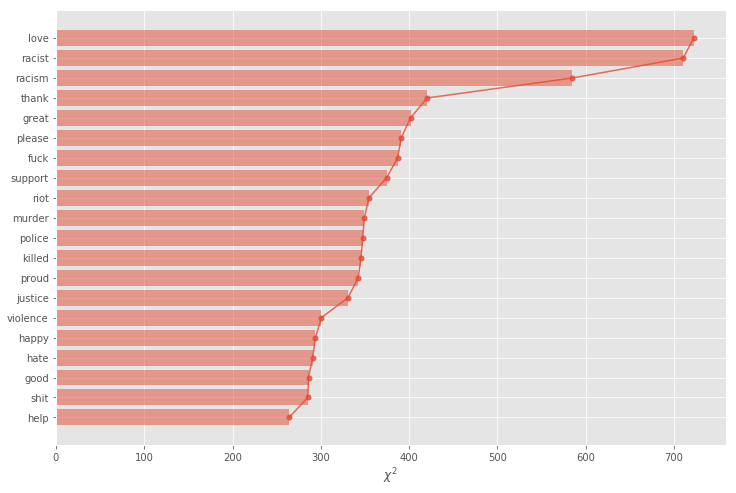

In [31]:
plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show()

From the Chi-square test we can see that the top words that influenced the sentiment were "love, racist, racism, thank, great, please, fuck, support" etc.